In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.special import j1
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import j1
from scipy.fft import fftshift, fft2, ifft2, ifftshift

@njit
def compute_radial_profile(I_norm, cx, cy, radius_int, bin_width_px):
    h = I_norm.shape[0]
    w = I_norm.shape[1]
    max_r_px = radius_int
    nbins = int(np.ceil(max_r_px / bin_width_px))

    bin_sums = np.zeros(nbins)
    bin_counts = np.zeros(nbins)

    for y in range(h):
        for x in range(w):
            r = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)
            if r < max_r_px:
                bin_idx = int(r // bin_width_px)
                if bin_idx < nbins:  
                    bin_sums[bin_idx] += I_norm[y, x]
                    bin_counts[bin_idx] += 1

    radial_mean = np.empty(nbins)
    for i in range(nbins):
        if bin_counts[i] > 0:
            radial_mean[i] = bin_sums[i] / bin_counts[i]
        else:
            radial_mean[i] = np.nan

    return radial_mean

def calc_radial_profile(gray, cx, cy, radius_int, pixel_to_mm, bin_width_px=1):
    if gray.ndim == 3:
        gray = gray.mean(axis=2)  # Convert RGB to grayscale if needed

    I_norm = (gray - np.min(gray)) / (np.max(gray) - np.min(gray))

    I_r = compute_radial_profile(I_norm, cx, cy, radius_int, bin_width_px)

    nbins = len(I_r)
    r_px = (np.arange(nbins) + 0.5) * bin_width_px
    r_mm = r_px * pixel_to_mm
    
    I_r = I_r - I_r.min()
    I_r = I_r/I_r.max()

    return I_r, r_mm

def plot_rad(I_theo, I_data, r_data, r_theo, plot_title, namess):
    plt.figure(figsize=(6, 4))
    plt.plot(r_data, I_data, '-o', markersize=3, label = "Data")

    plt.plot(r_theo, I_theo, '-x',markersize = 1, label = "Expected")
    
    plt.xlabel('Radius (a.u)')
    plt.ylabel('Normalized Intensity')
    plt.title(f'Poisson Spot Radial Profile {namess}')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{plot_title}.pdf")    
#     plt.semilogy()
    plt.show()

# def plot_intensity(I_data, r_data, radius_int, pixel_to_mm, wavelength, plot_title2):
#     z =  1.356
#     a = radius_int*pixel_to_mm
#     theta = np.linspace(0, 2*np.pi, 1000)
#     xc = a * np.cos(theta)
#     yc = a * np.sin(theta)

#     x = np.linspace(-max(r_data), max(r_data), len(r_data))
#     X, Y = np.meshgrid(x, x)
#     r = np.sqrt(X**2 + Y**2)

#     # === Compute far-field diffraction amplitude and intensity (Airy pattern from complementary aperture) ===
#     k = 2 * np.pi / wavelength
#     krz = k * a*1e-3 * r / z
#     amplitude = np.ones_like(r)
#     nonzero = krz != 0
#     amplitude[nonzero] = 2 * j1(krz[nonzero]) / krz[nonzero]
#     intensity = amplitude**2

#     # Normalize
#     intensity /= intensity.max()

#     # === Plot 1: 2D intensity map ===
#     plt.figure()
#     plt.imshow(intensity, extent=(-2*max(r_data) - 0.5, 2*max(r_data) + 0.5, -2*max(r_data) - 0.5, 2*max(r_data) + 0.5))
#     plt.plot(xc, yc, 'r-', linewidth=1.5, label='Disk edge')
#     plt.xlabel('x (mm)')
#     plt.ylabel('y (mm)')
#     plt.title('Simulated Poisson Spot Intensity')
#     plt.colorbar(label='Normalized Intensity')
#     plt.tight_layout()
#     plt.savefig(f"{plot_title2}.pdf")
#     plt.show()

def calc_theo(z, wavelength, D):
    k = 2 * np.pi / wavelength
    diameter = D  # ball diameter in meters
    radius = diameter / 2
    
    # Grid setup
    L = D*2  # simulation window size (10 mm)
    N = 2048  # resolution
    dx = L / N
    x = np.linspace(-L/2, L/2, N)
    X, Y = np.meshgrid(x, x)
    R = np.sqrt(X**2 + Y**2)

    # Aperture (opaque disk)
    aperture = np.ones((N, N))
    aperture[R < radius] = 0  # block light inside disk

    # Fresnel diffraction using angular spectrum method
    # Step 1: input field
    U0 = aperture

    # Step 2: Fourier coordinates
    fx = np.fft.fftfreq(N, dx)
    FX, FY = np.meshgrid(fx, fx)
    f_squared = FX**2 + FY**2

    # Step 3: Angular spectrum propagation
    H = np.exp(-1j * np.pi * wavelength * z * f_squared)
    U1 = (ifft2(fft2(U0) * H))
#     U1 = ifftshift(U1_shifted)
    # Intensity pattern
    I_fresnel = np.abs(U1)**2
    I_fresnel /= np.max(I_fresnel)

    # Extract radial profile from center
    center = N // 2
    print(N)
    r_axis = np.linspace(0, L/2, N//2)
    radial_profile = I_fresnel[center, center:N]

    # Plot results
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # 2D pattern
    axs[0].imshow(I_fresnel, cmap='inferno', extent=[-L/2*1e3, L/2*1e3, -L/2*1e3, L/2*1e3])
    axs[0].set_title("Fresnel Diffraction Pattern")
    axs[0].set_xlabel("x (mm)")
    axs[0].set_ylabel("y (mm)")

    # Radial profile
    axs[1].plot(r_axis[:len(r_axis)//2] * 1e3, radial_profile[:len(r_axis)//2])
    axs[1].set_title("Radial Intensity Profile (Fresnel)")
    axs[1].set_xlabel("Radius (mm)")
    axs[1].set_ylabel("Normalized Intensity")
    axs[1].grid(True)

    plt.tight_layout()
    plt.savefig(f"theo_{wavelength * 1e9:.2f}_{D * 1e3:.2f}.pdf")
    plt.show()
    I_theo = radial_profile[:len(r_axis)//2]
    I_theo = I_theo/I_theo.max()
    r_theo = r_axis[:len(r_axis)//2]*1e3
    return I_theo, r_theo

## Green Laser

In [2]:



# k = 2 * np.pi / wavelength
# diameter = D  # ball diameter in meters
# radius = diameter / 2

# # Grid setup
# L = 0.01  # simulation window size (10 mm)
# N = 2048  # resolution
# dx = L / N
# x = np.linspace(-L/2, L/2, N)
# X, Y = np.meshgrid(x, x)
# R = np.sqrt(X**2 + Y**2)

# # Aperture (opaque disk)
# aperture = np.ones((N, N))
# aperture[R < radius] = 0  # block light inside disk

# # Fresnel diffraction using angular spectrum method
# # Step 1: input field
# U0 = aperture

# # Step 2: Fourier coordinates
# fx = np.fft.fftfreq(N, dx)
# FX, FY = np.meshgrid(fx, fx)
# f_squared = FX**2 + FY**2

# # Step 3: Angular spectrum propagation
# H = np.exp(-1j * np.pi * wavelength * z * f_squared)
# U1_shifted = fftshift(ifft2(fft2(U0) * H))
# U1 = ifftshift(U1_shifted)
# # Intensity pattern
# I_fresnel = np.abs(U1)**2
# I_fresnel /= np.max(I_fresnel)

# # Extract radial profile from center
# center = N // 2
# print(N)
# r_axis = np.linspace(0, radius, N//2)
# radial_profile = I_fresnel[center, center:N]

# # Plot results
# fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# # 2D pattern
# axs[0].imshow(I_fresnel, cmap='inferno', extent=[-L/2*1e3, L/2*1e3, -L/2*1e3, L/2*1e3])
# axs[0].set_title("Fresnel Diffraction Pattern")
# axs[0].set_xlabel("x (mm)")
# axs[0].set_ylabel("y (mm)")

# # Radial profile
# axs[1].plot(r_axis[:len(r_axis)//2] * 1e3, radial_profile[:len(r_axis)//2])
# axs[1].set_title("Radial Intensity Profile (Fresnel)")
# axs[1].set_xlabel("Radius (mm)")
# axs[1].set_ylabel("Normalized Intensity")
# axs[1].grid(True)

# plt.tight_layout()
# plt.show()

In [3]:
wavelength = 532e-9
z =  1.356 

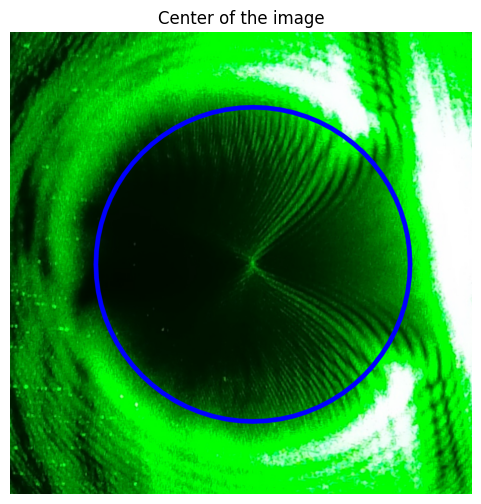

In [4]:
image_path = 'Plots and Data/B2_Files/Green/1.png'
sphere_diameter_mm = 4.92                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = img.copy()
cx = 2554.7 + 75
cy = 2634.0 - 120

center_int = (int(cx), int(cy))
radius_int = 1700
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 50, (255, 0, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (0, 0, 255), 50)  # red circle

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Green_{sphere_diameter_mm}.pdf")
plt.show()

2048


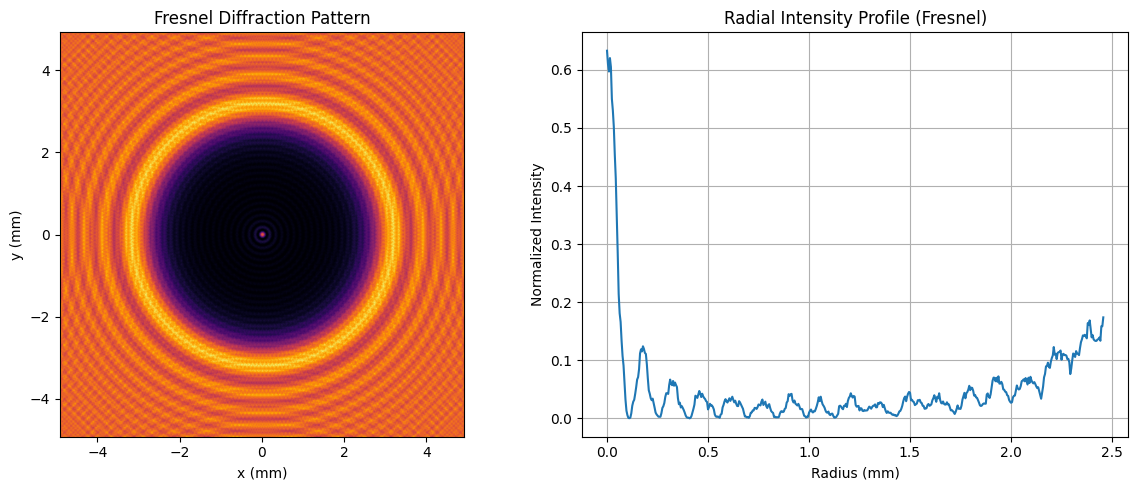

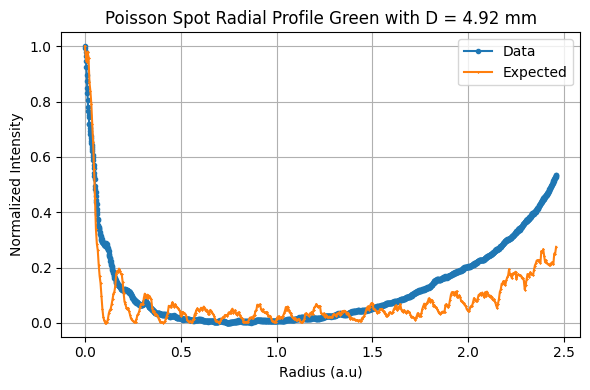

Fresnel Number:  8.388781688735111


In [5]:
D = 4.92e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int, pixel_to_mm)
I_theo, r_theo = calc_theo(z, wavelength, D)
plot_rad(I_theo, I_data, r_data, r_theo, f"G_Rad_{D * 1e3:.2f}", f"Green with D = {D * 1e3:.2f} mm")
print("Fresnel Number: ", ((D/2)**2)/(z*wavelength))

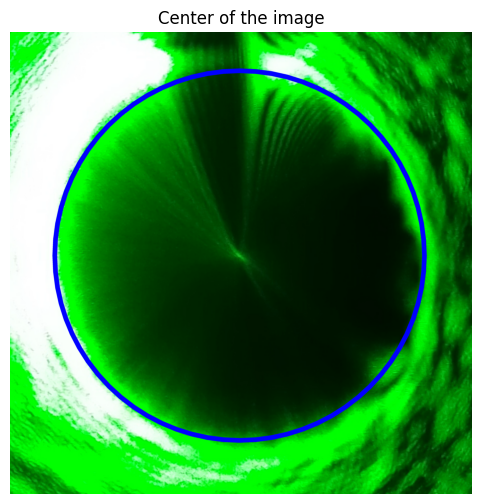

In [6]:
image_path = 'Plots and Data/B2_Files/Green/2.png'
sphere_diameter_mm = 7.05                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = img.copy()
cx = 2554.7 - 70
cy = 2634.0 - 215

center_int = (int(cx), int(cy))
radius_int = 2000
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 50, (255, 0, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (0, 0, 255), 50)  # red circle

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Green_{sphere_diameter_mm}.pdf")
plt.show()

2048


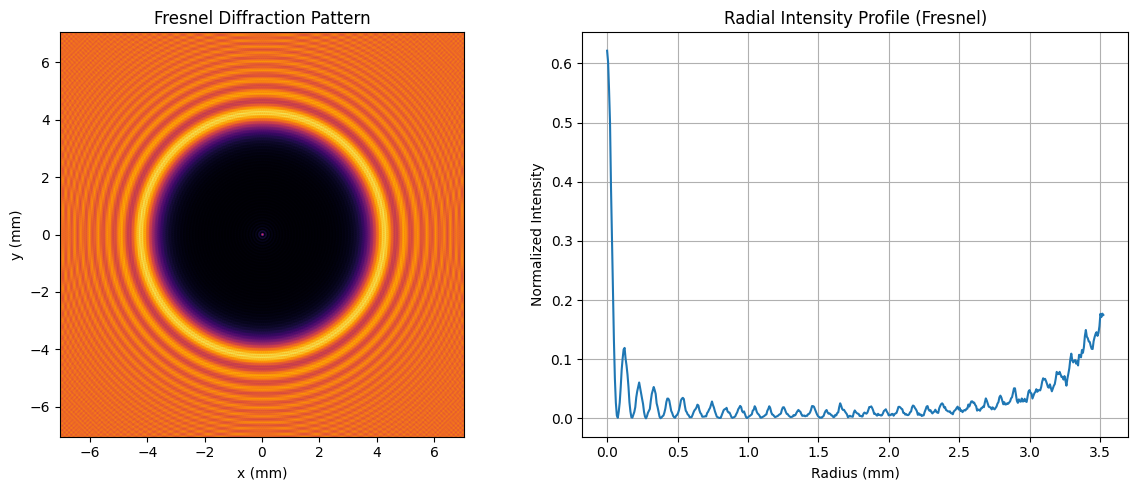

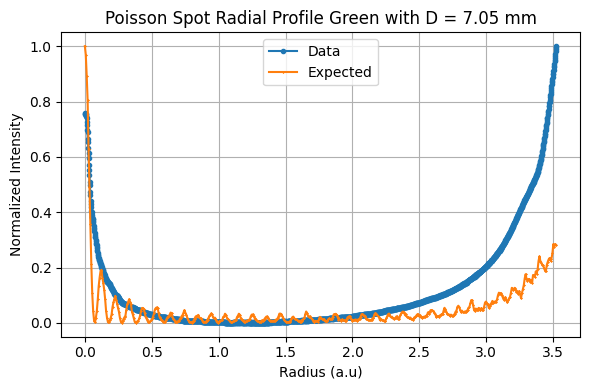

Fresnel Number:  17.224511777230685


In [7]:
D = 7.05e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int, pixel_to_mm)
I_theo, r_theo = calc_theo(z, wavelength, D)
plot_rad(I_theo, I_data, r_data, r_theo, f"G_Rad_{D * 1e3:.2f}", f"Green with D = {D * 1e3:.2f} mm")
print("Fresnel Number: ", ((D/2)**2)/(z*wavelength))

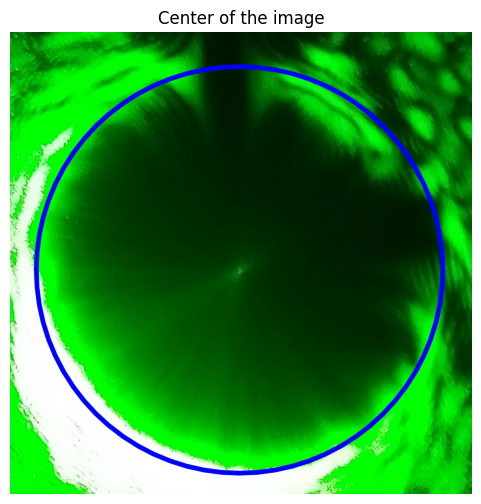

In [8]:
image_path = 'Plots and Data/B2_Files/Green/3.png'
sphere_diameter_mm = 7.92                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = img.copy()
cx = 2554.7 - 70
cy = 2634.0 - 60

center_int = (int(cx), int(cy))
radius_int = 2200
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 50, (255, 0, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (0, 0, 255), 50)  # red circle

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Green_{sphere_diameter_mm}.pdf")
plt.show()

2048


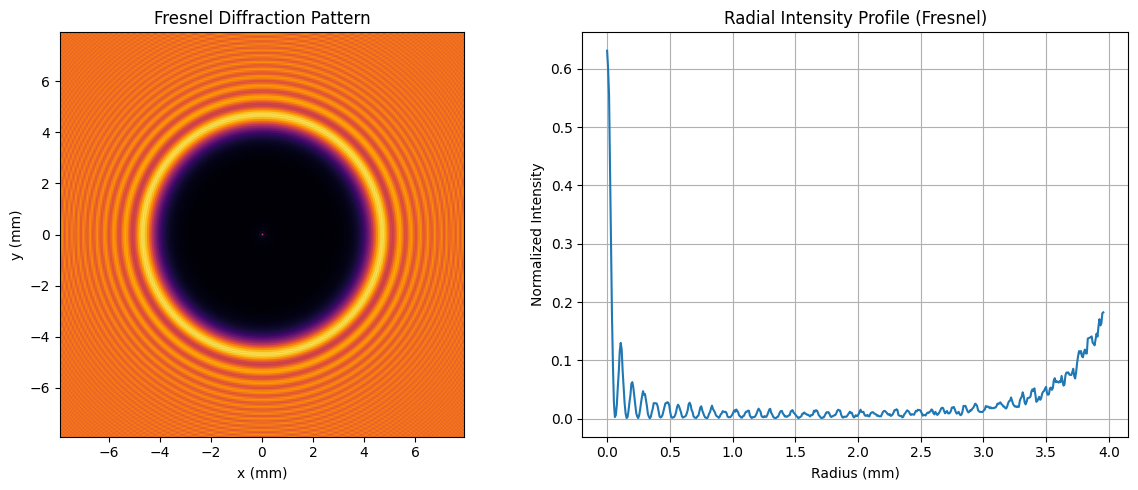

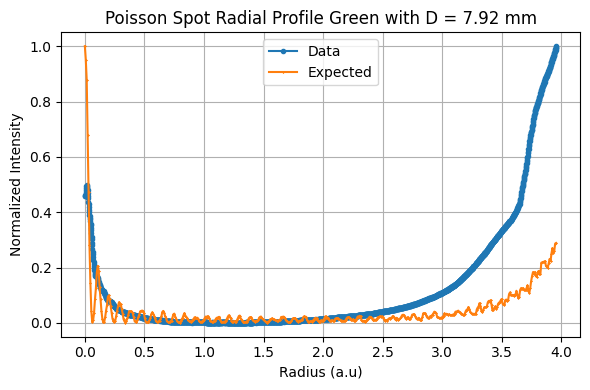

Fresnel Number:  21.73797325171335


In [9]:
D = sphere_diameter_mm*1e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int, pixel_to_mm)
I_theo, r_theo = calc_theo(z, wavelength, D)
plot_rad(I_theo, I_data, r_data, r_theo, f"G_Rad_{D * 1e3:.2f}", f"Green with D = {D * 1e3:.2f} mm")
print("Fresnel Number: ", ((D/2)**2)/(z*wavelength))

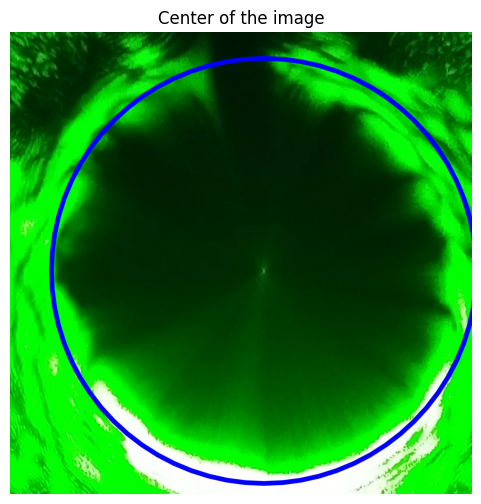

In [10]:
image_path = 'Plots and Data/B2_Files/Green/4.png'
sphere_diameter_mm = 8.95                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = img.copy()
cx = 2554.7 + 194
cy = 2634.0 - 49

center_int = (int(cx), int(cy))
radius_int = 2300
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 50, (255, 0, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (0, 0, 255), 50)  # red circle

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Green_{sphere_diameter_mm}.pdf")
plt.show()

2048


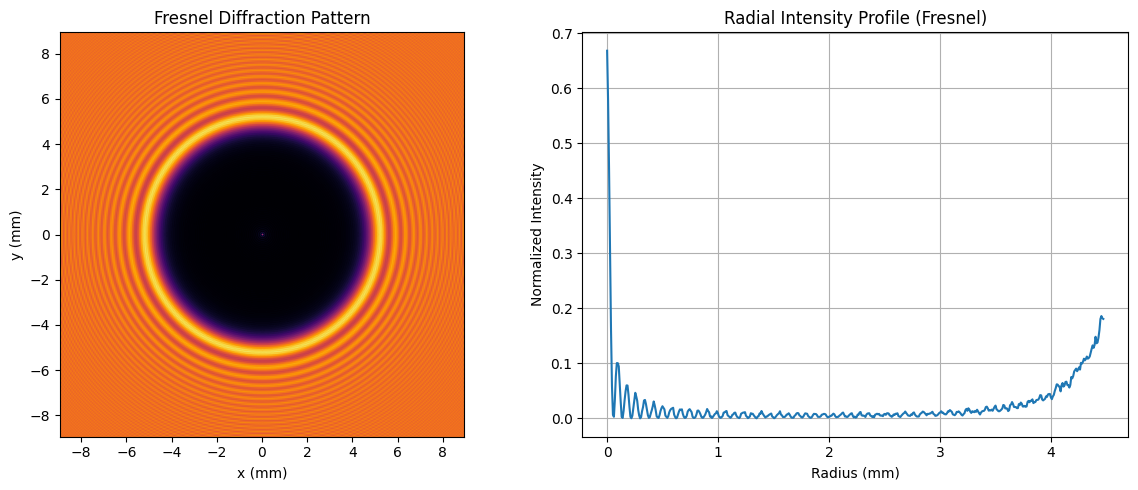

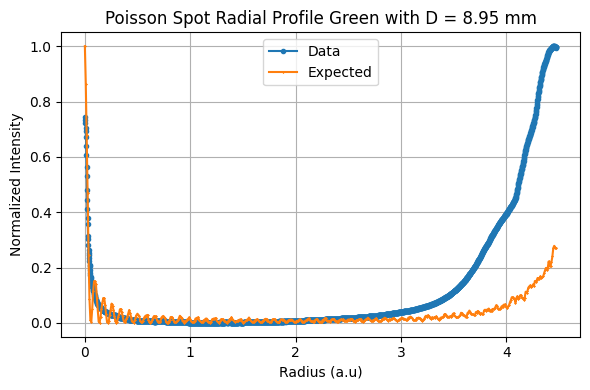

Fresnel Number:  27.759699303568652


In [11]:
D = sphere_diameter_mm*1e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int, pixel_to_mm)
I_theo, r_theo = calc_theo(z, wavelength, D)
plot_rad(I_theo, I_data, r_data, r_theo, f"G_Rad_{D * 1e3:.2f}", f"Green with D = {D * 1e3:.2f} mm")
print("Fresnel Number: ", ((D/2)**2)/(z*wavelength))

## Red Laser

In [12]:
wavelength = 650e-9
z =  1.356 

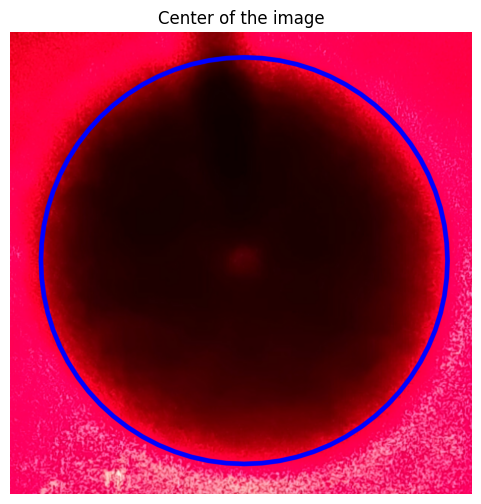

In [13]:
image_path = 'Plots and Data/B2_Files/Red/5.png'
sphere_diameter_mm = 4.92                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = rgb_image.copy()
cx = 2554.7 - 20
cy = 2634.0 - 160

center_int = (int(cx), int(cy))
radius_int = 2200
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 50, (0, 255, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (0, 0, 255), 50)  

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Red_{sphere_diameter_mm}.pdf")
plt.show()

2048


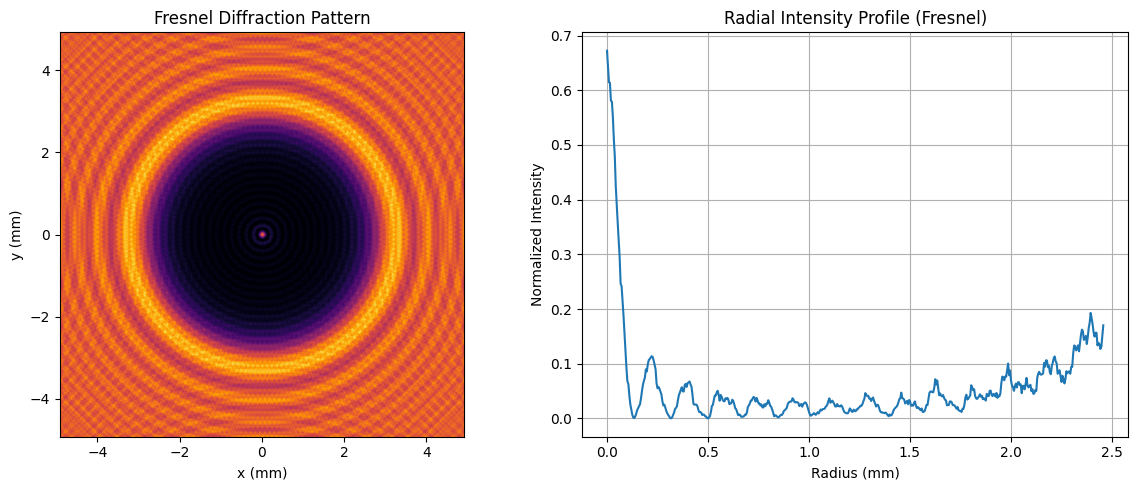

Fresnel Number:  6.865895166780122


In [14]:
D = sphere_diameter_mm*1e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int, pixel_to_mm)
I_theo, r_theo = calc_theo(z, wavelength, D)
plot_rad(I_theo, I_data, r_data, r_theo, f"R_Rad_{D * 1e3:.2f}", f"Red with D = {D * 1e3:.2f} mm")
print("Fresnel Number: ", ((D/2)**2)/(z*wavelength))

In [15]:
image_path = 'Plots and Data/B2_Files/Red/6.png'
sphere_diameter_mm = 7.05                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = rgb_image.copy()
cx = 2554.7 - 21
cy = 2634.0 - 120

center_int = (int(cx), int(cy))
radius_int = 2200
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 50, (0, 255, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (0, 0, 255), 50)  

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Red_{sphere_diameter_mm}.pdf")
plt.show()

1.7625
2048


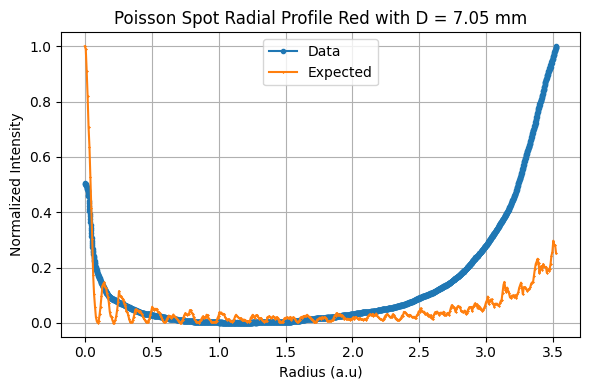

Fresnel Number:  14.097600408441116


In [16]:
D = sphere_diameter_mm*1e-3
print(radius_int/2*pixel_to_mm)
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int, pixel_to_mm)
I_theo, r_theo = calc_theo(z, wavelength, D)
plot_rad(I_theo, I_data, r_data, r_theo, f"R_Rad_{D * 1e3:.2f}", f"Red with D = {D * 1e3:.2f} mm")
print("Fresnel Number: ", ((D/2)**2)/(z*wavelength))

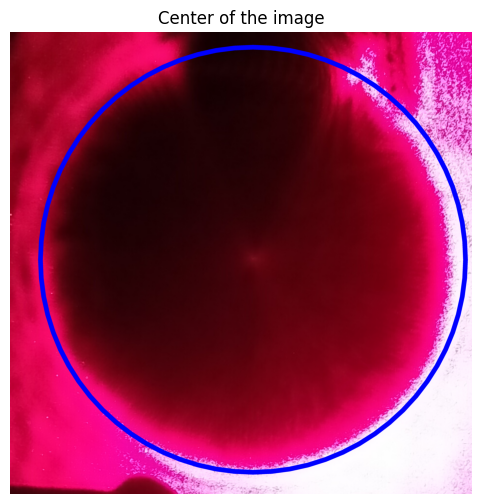

In [17]:
image_path = 'Plots and Data/B2_Files/Red/7.png'
sphere_diameter_mm = 7.92                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = rgb_image.copy()
cx = 2554.7 + 75
cy = 2634.0 - 170

center_int = (int(cx), int(cy))
radius_int = 2300
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 50, (0, 255, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (0, 0, 255), 50)  

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Red_{sphere_diameter_mm}.pdf")
plt.show()

2048


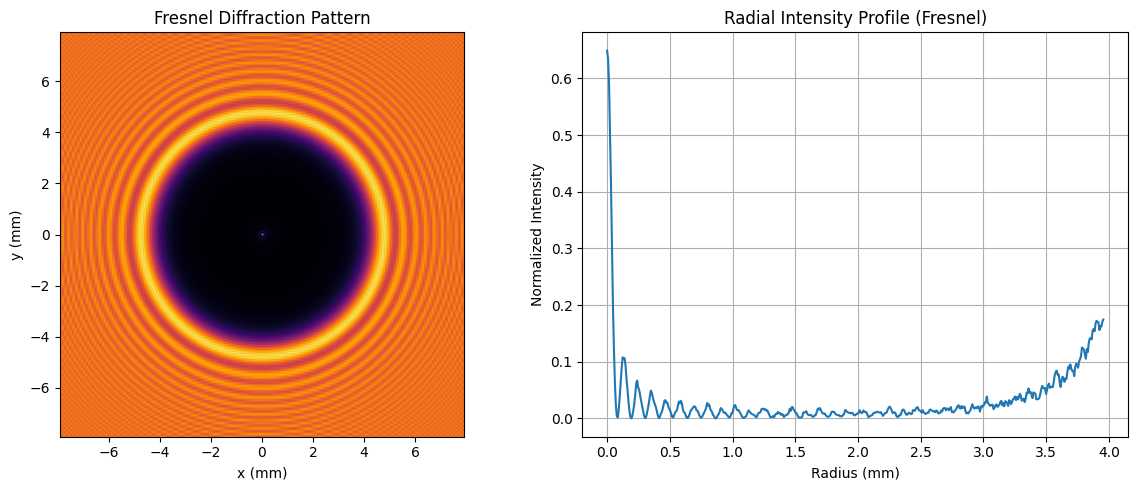

Fresnel Number:  17.791695030633083


In [18]:
D = sphere_diameter_mm*1e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int, pixel_to_mm)
I_theo, r_theo = calc_theo(z, wavelength, D)
plot_rad(I_theo, I_data, r_data, r_theo, f"R_Rad_{D * 1e3:.2f}", f"Red with D = {D * 1e3:.2f} mm")
print("Fresnel Number: ", ((D/2)**2)/(z*wavelength))

In [19]:
image_path = 'Plots and Data/B2_Files/Red/8.png'
sphere_diameter_mm = 8.95                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = rgb_image.copy()
cx = 2554.7 
cy = 2634.0 - 177

center_int = (int(cx), int(cy))
radius_int = 2200
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 50, (0, 255, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (0, 0, 255), 50)  

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Red_{sphere_diameter_mm}.pdf")
plt.show()

2048


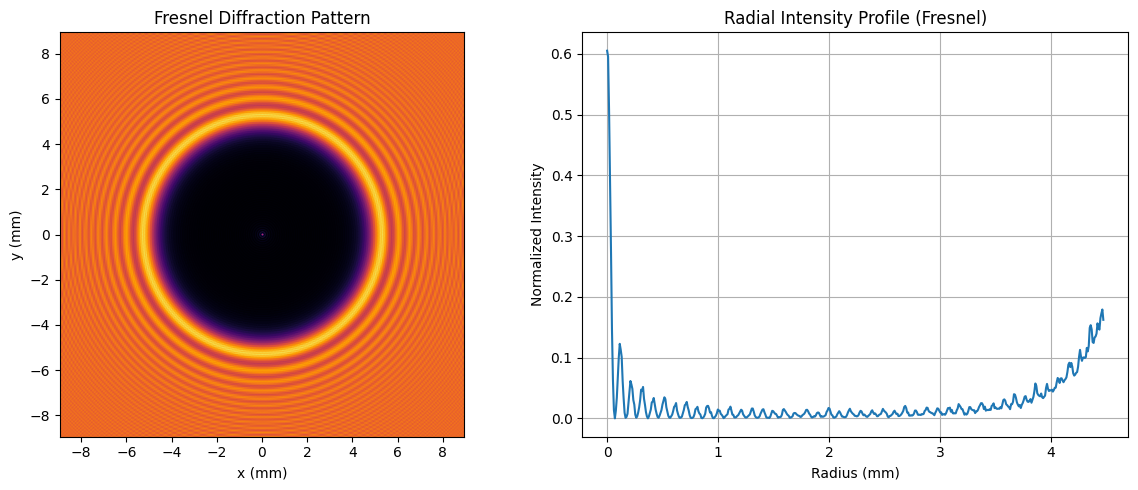

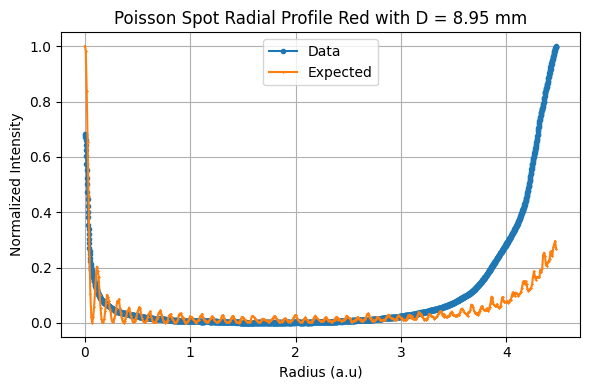

Fresnel Number:  22.720246199228498


In [20]:
D = sphere_diameter_mm*1e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int, pixel_to_mm)
I_theo, r_theo = calc_theo(z, wavelength, D)
plot_rad(I_theo, I_data, r_data, r_theo, f"R_Rad_{D * 1e3:.2f}", f"Red with D = {D * 1e3:.2f} mm")
print("Fresnel Number: ", ((D/2)**2)/(z*wavelength))

## Violet

In [21]:
wavelength = 405e-9
z =  1.356 

In [22]:
image_path = 'Plots and Data/B2_Files/Violet/9.png'
sphere_diameter_mm = 4.92                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = rgb_image.copy()
cx = 2554.7 + 35
cy = 2634.0 - 115

center_int = (int(cx), int(cy))
radius_int = 2200
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 5, (0, 255, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (255, 0, 0), 50)  

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Violet_{sphere_diameter_mm}.pdf")
plt.show()

2048


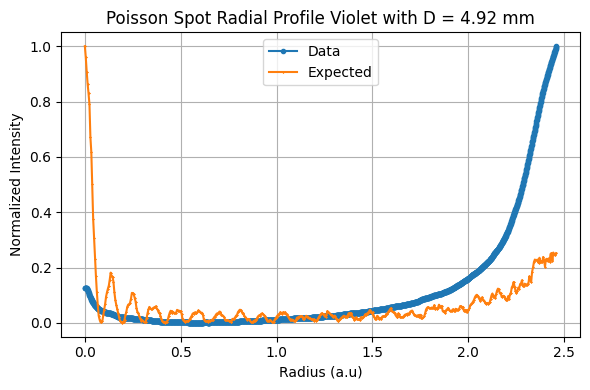

Fresnel Number:  11.019337921992788


In [23]:
D = sphere_diameter_mm*1e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int, pixel_to_mm)
I_theo, r_theo = calc_theo(z, wavelength, D)
plot_rad(I_theo, I_data, r_data, r_theo, f"V_Rad_{D * 1e3:.2f}", f"Violet with D = {D * 1e3:.2f} mm")
print("Fresnel Number: ", ((D/2)**2)/(z*wavelength))

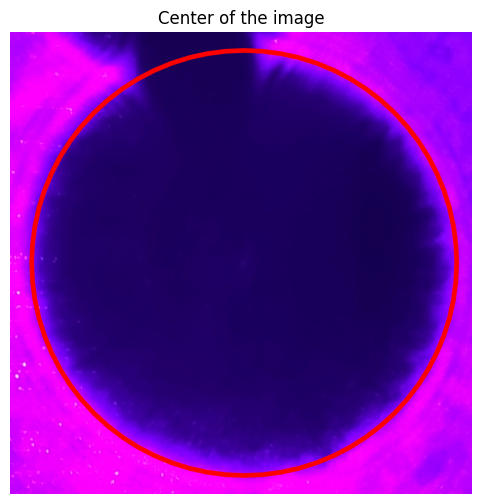

In [24]:
image_path = 'Plots and Data/B2_Files/Violet/10.png'
sphere_diameter_mm = 7.05                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = rgb_image.copy()
cx = 2554.7 + 35 - 50 -5
cy = 2634.0 - 115 - 5 - 15

center_int = (int(cx), int(cy))
radius_int = 2300
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 5, (0, 255, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (255, 0, 0), 50)  

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Violet_{sphere_diameter_mm}.pdf")
plt.show()

2048


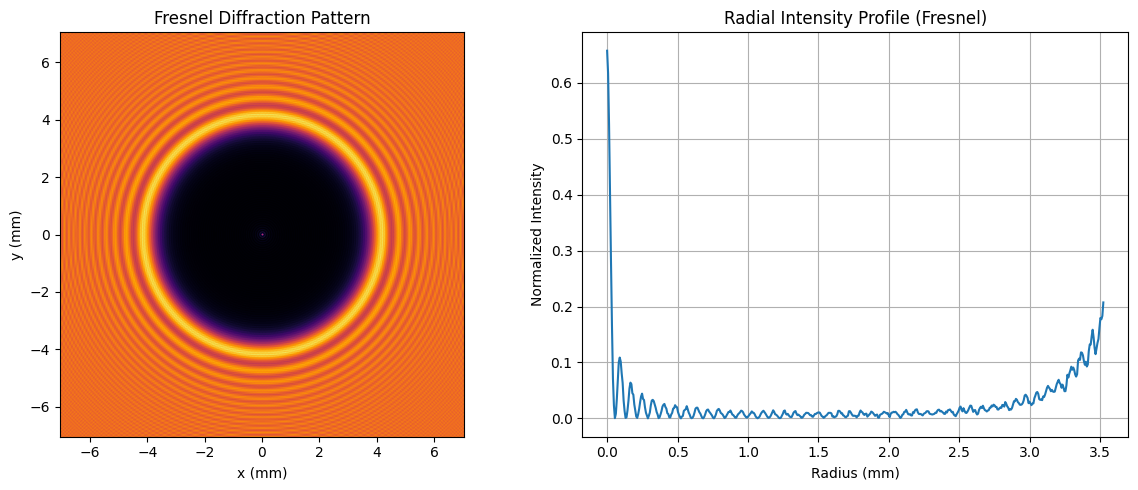

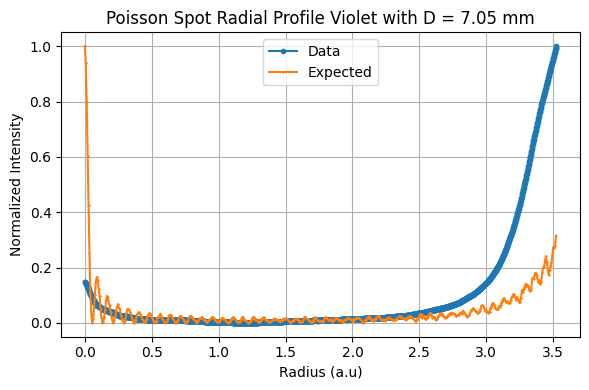

Fresnel Number:  22.625778433300557


In [25]:
D = sphere_diameter_mm*1e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int, pixel_to_mm)
I_theo, r_theo = calc_theo(z, wavelength, D)
plot_rad(I_theo, I_data, r_data, r_theo, f"V_Rad_{D * 1e3:.2f}", f"Violet with D = {D * 1e3:.2f} mm")
print("Fresnel Number: ", ((D/2)**2)/(z*wavelength))

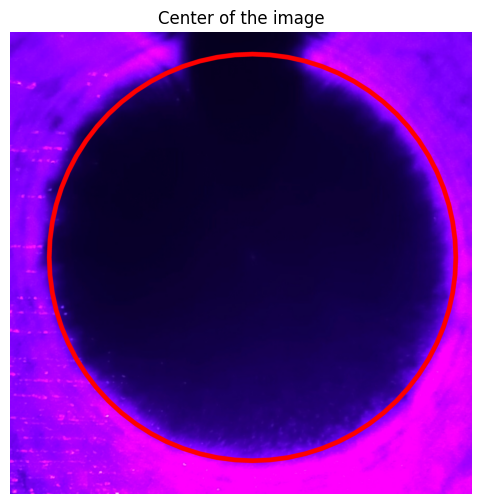

In [26]:
image_path = 'Plots and Data/B2_Files/Violet/11.png'
sphere_diameter_mm = 7.92                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = rgb_image.copy()
cx = 2554.7 + 35 + 10 + 25
cy = 2634.0 - 215 + 20

center_int = (int(cx), int(cy))
radius_int = 2200
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 5, (0, 255, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (255, 0, 0), 50)  

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Violet_{sphere_diameter_mm}.pdf")
plt.show()

2048


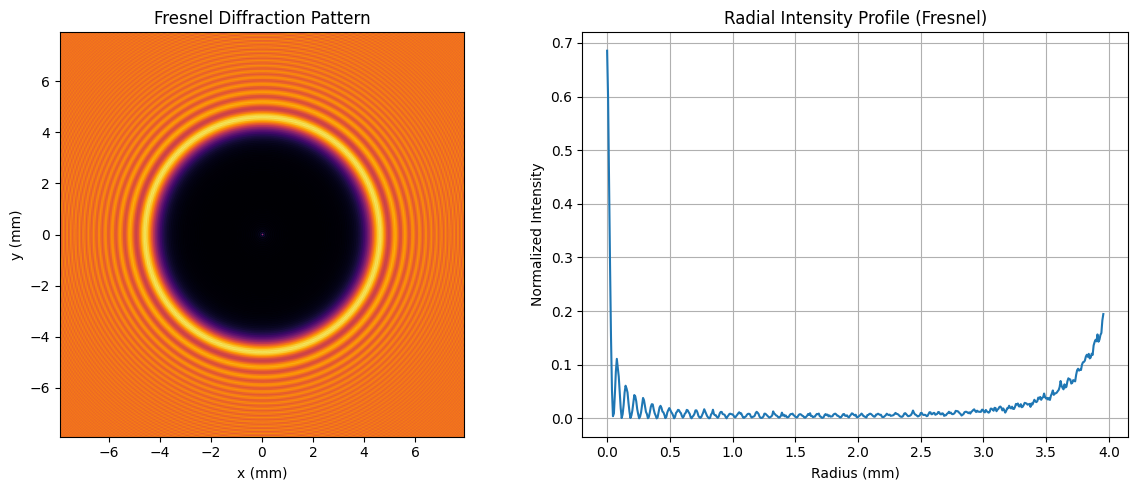

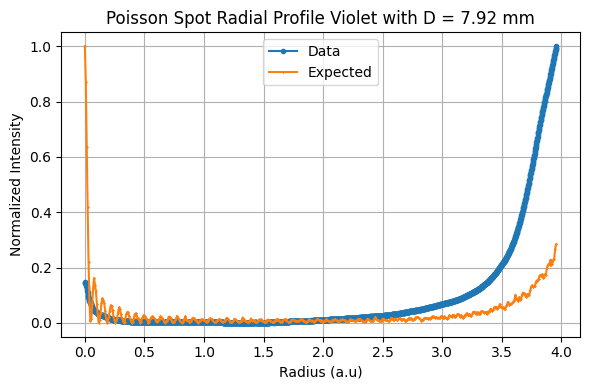

Fresnel Number:  28.554572271386427


In [27]:
D = sphere_diameter_mm*1e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int, pixel_to_mm)
I_theo, r_theo = calc_theo(z, wavelength, D)
plot_rad(I_theo, I_data, r_data, r_theo, f"V_Rad_{D * 1e3:.2f}", f"Violet with D = {D * 1e3:.2f} mm")
print("Fresnel Number: ", ((D/2)**2)/(z*wavelength))

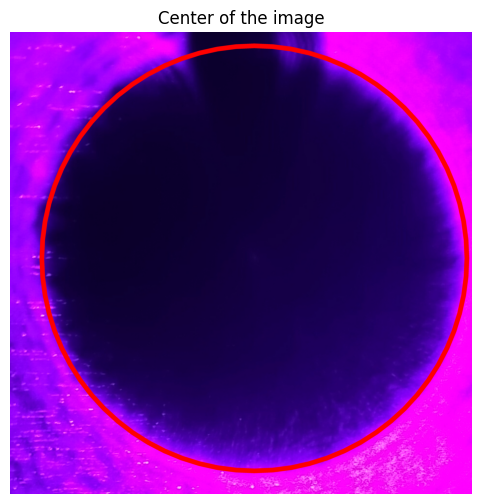

In [28]:
image_path = 'Plots and Data/B2_Files/Violet/12.png'
sphere_diameter_mm = 8.95                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = rgb_image.copy()
cx = 2554.7 + 35 + 20 + 10 + 20 + 5
cy = 2634.0 - 115 - 20 - 20 - 20 - 10

center_int = (int(cx), int(cy))
radius_int = 2300
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 5, (0, 255, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (255, 0, 0), 50)  

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Violet_{sphere_diameter_mm}.pdf")
plt.show()

2048


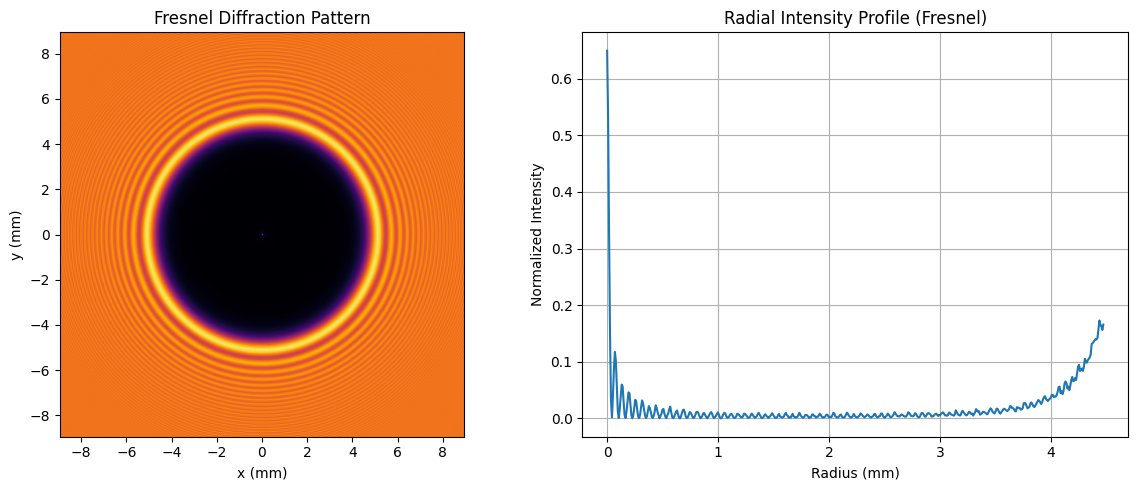

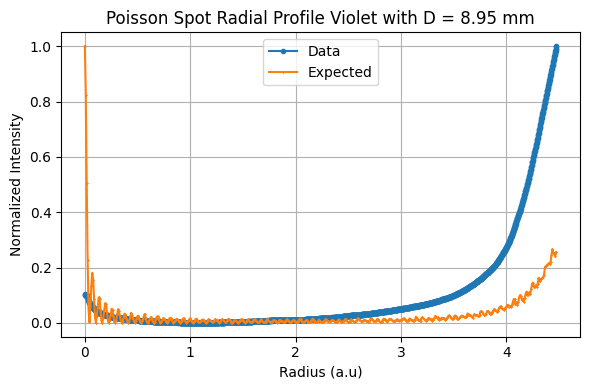

Fresnel Number:  36.46459266542845


In [29]:
D = sphere_diameter_mm*1e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int, pixel_to_mm)
I_theo, r_theo = calc_theo(z, wavelength, D)
plot_rad(I_theo, I_data, r_data, r_theo, f"V_Rad_{D * 1e3:.2f}", f"Violet with D = {D * 1e3:.2f} mm")
print("Fresnel Number: ", ((D/2)**2)/(z*wavelength))